<center>
    <h1>Football field Analysis</h1>
    <b>VIC Project, Main Code</b><br>
    <i>Coded By Chloé DAEMS, Amir MAHMOUDI & Anne-Claire LAISNEY</i>
</center>

<b> Sources :</b> <br>
<i>https://link.springer.com/chapter/10.1007/978-3-540-30125-7_101</i> pp 818-824. 2004 - Use hue detection to detect grass (ie field) -- The results seems not usable for us <br>
<i> https://static1.squarespace.com/static/5b048119f2e6b103db959419/t/5e99aeb4d85a234bb8752f78/1587130062444/Learning+to+track+and+identify+players+from+broadcast+sports+videos.pdf </i> Canny Edge detector to detect the field lines <br>
<i>https://www.cse.ust.hk/~quan/comp5421/notes/canny1986.pdf</i> Paper on the Canny detector

<b>Python libraries imports</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

**Import the image**

(350, 625)


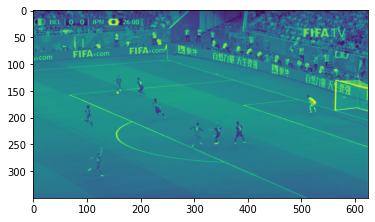

In [2]:
from skimage.transform import resize
img = cv2.imread("input_img1.png",cv2.IMREAD_GRAYSCALE) 
img = resize(img, output_shape=(350, 625))
print(img.shape)
plt.imshow(img)

## Step 1 : Canny Edge detector

**We are first going to try a step by step pipeline for image preparation and the canny edge detector, inspired by the work done in assignment 1 part 2.**

**A. Smooth the image**

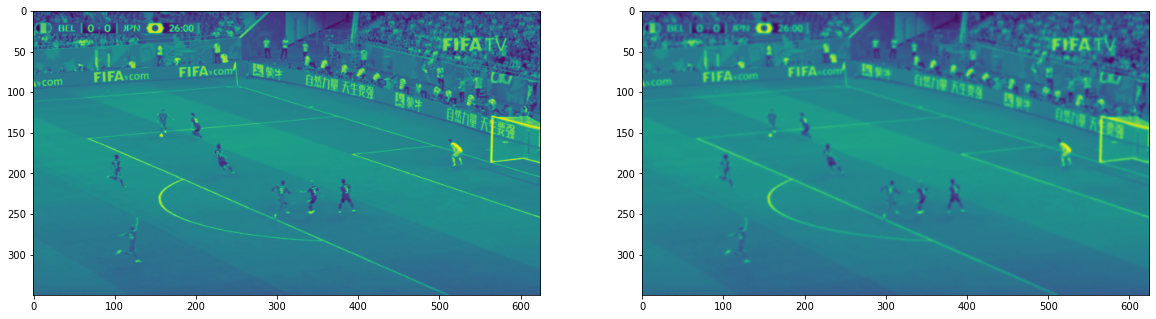

In [3]:
from scipy.ndimage import gaussian_filter
smoothed = gaussian_filter(img, sigma=1)
fig, axes = plt.subplots(figsize=(20, 12), ncols=2)
axes[0].imshow(img) 
axes[1].imshow(smoothed)

**B. Gradients**

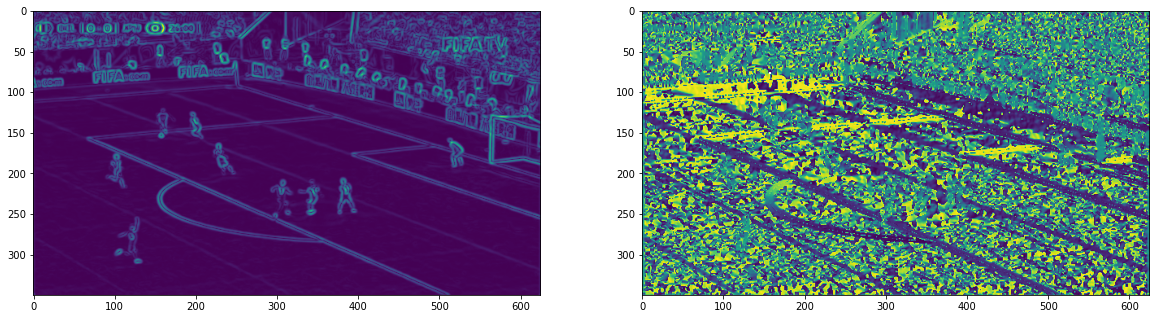

In [4]:
from skimage.filters import sobel 
def gradient(img):
    g_x = sobel(img, axis=1) 
    g_y = sobel(img, axis=0)
    g_mag = np.sqrt(g_x**2 + g_y**2) 
    g_dir = np.arctan(g_y / g_x)
    return g_mag, g_dir
fig, axes = plt.subplots(figsize=(20, 12), ncols=2) 
g_magnitude, g_dir = gradient(smoothed)
axes[0].imshow(g_magnitude) 
axes[1].imshow(g_dir)

**C. Non-maximum suppression**

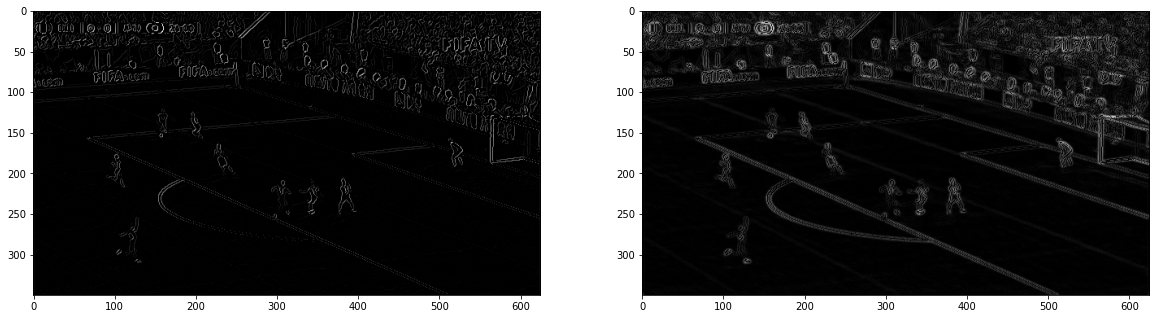

In [5]:
def non_maximum_suppression(g_magnitude, g_dir):
    #quantise the gradient directions into 4 values np.array([0, np.pi/4, np.pi/2, 3*np.pi/4])
    h, w = g_magnitude.shape 
    values = np.array([0, np.pi, np.pi/4, np.pi/2, 3*np.pi/4])
    g_max = np.zeros_like(g_magnitude)
    for i in range(h-1):
        for j in range(w-1):
            diff = abs(values - g_dir[i,j])
            angle = values[np.argmin(diff)]
            q = 0
            r = 0
            #case angle = 0
            if angle == 0 or angle == 1 :
                q = g_magnitude[i, j+1]
                r = g_magnitude[i, j-1]
            #case angle = pi/4
            elif angle == 2:
                q = g_magnitude[i+1, j-1]
                r = g_magnitude[i-1, j+1]
            #case angle = pi/2 
            elif angle == 3:
                q = g_magnitude[i+1, j]
                r = g_magnitude[i-1, j]
            #case angle = 3pi/4
            else:
                q = g_magnitude[i-1, j-1]
                r = g_magnitude[i+1, j+1]
                
            if g_magnitude[i,j] >= q and g_magnitude[i,j]>=r : 
                g_max[i,j] = g_magnitude[i,j]
            else:
                g_max[i,j] = 0

    return g_max

fig, axes = plt.subplots(figsize=(20, 12), ncols=2)

g_max = non_maximum_suppression(g_magnitude, g_dir)

axes[0].imshow(g_max, cmap='gray')
axes[1].imshow(g_magnitude - g_max, cmap='gray')

**D. Double Thresholding**

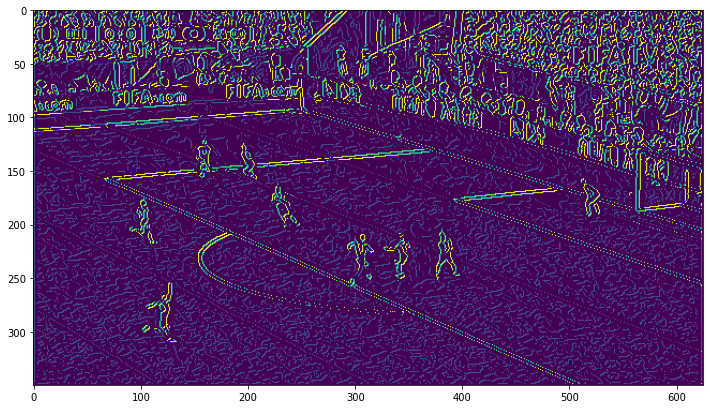

In [6]:
def double_thresholding(g_max, thresh_lo, thresh_hi):
    h, w = g_max.shape
    thresh_img = np.zeros_like(g_max)
    highThreshold = g_max.max() * thresh_hi;
    lowThreshold = highThreshold * thresh_lo;
    
    for i in range(h):
        for j in range(w):
            if g_max[i,j] > highThreshold :
                 thresh_img[i,j] = 1
            elif g_max[i,j] > lowThreshold:
                thresh_img[i,j] = 0.25

    return thresh_img

thresh_img = double_thresholding(g_max, thresh_lo=0.05, thresh_hi=0.08)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(thresh_img)

**E. Edge connectivity**

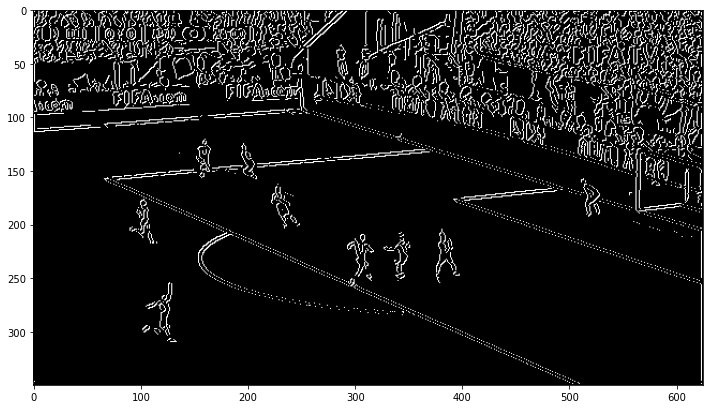

In [7]:
def connectivity(thresh_img):
    h, w = thresh_img.shape
    edge_img = thresh_img
    
    for i in range(h):
        for j in range(w):
            if edge_img[i,j] == 0.25:
                if edge_img[i+1,j] == 1 or edge_img[i+1,j+1] == 1 or edge_img[i,j+1] == 1 or edge_img[i-1,j] == 1 or edge_img[i-1,j-1] == 1 or edge_img[i,j-1] == 1 or edge_img[i+1,j-1] == 1 or edge_img[i-1,j+1] == 1:
                    edge_img[i,j] = 1 
                else:
                    edge_img[i,j] = 0

    return edge_img

edge_img = connectivity(thresh_img)

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(edge_img, cmap='gray')

#### Canny detector Pipeline

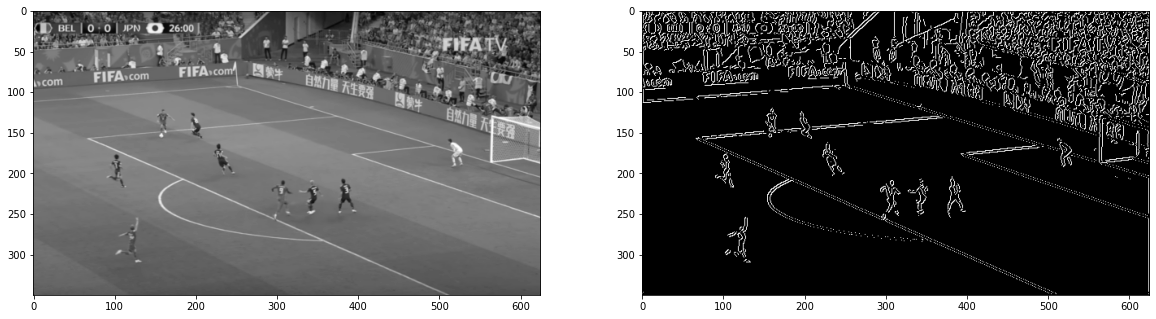

In [10]:
def canny_edge_detector(img, thresh_lo=0.1, thresh_hi=0.2):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_filter(img,1)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img


fig, axes = plt.subplots(figsize=(20, 12), ncols=2)

edges = canny_edge_detector(img, thresh_lo=0.05, thresh_hi=0.09)

axes[0].imshow(img, cmap='gray')
axes[1].imshow(edges, cmap='gray')

<div class="alert alert-block alert-success">
<b>Next step:</b> Here, you can see that the players are noising the detections of the fields'line, in the Lu's Paper they decided to detect the bounding boxes of the players to delete them from the edge detection. This is what we are going to try to do next.
</div>

### Find the players on the field
Main ref paper : http://cs.brown.edu/people/pfelzens/papers/latent.pdf (seen in course)

https://www.cs.toronto.edu/~fidler/slides/2015/CSC420/lecture19.pdf (course on DPM detector -- based on Hog detector)

http://ipl.ce.sharif.edu/azadi_soccer_dataset.html (dataset 1 -- emailed the owner)

**First we try a classic HOG + SVM from opencv**

[INFO]: 33 original boxes, 31 after suppression


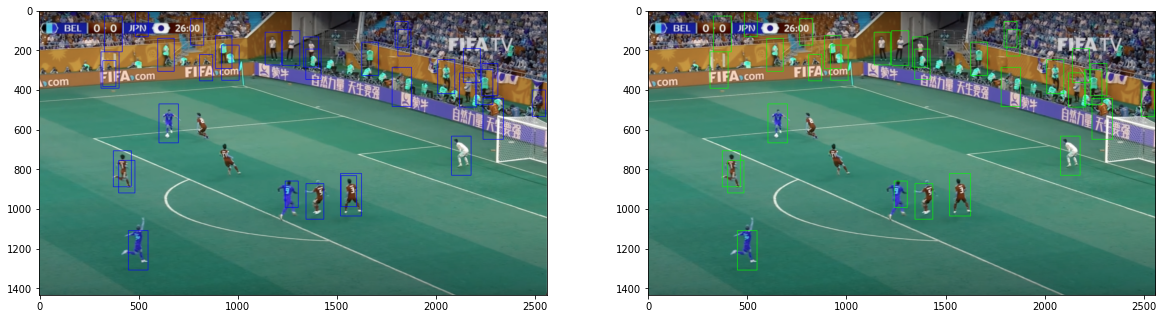

In [38]:
from imutils.object_detection import non_max_suppression
import argparse
import imutils

image = cv2.imread("input_img1.png")

# initialize the HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

#image = imutils.resize(image, height = 350, width=625)
#image = resize(img, output_shape=(350, 625))
orig = image.copy()
# detect people in the image
(rects, weights) = hog.detectMultiScale(image, winStride=(5, 5), scale = 1.01)
# draw the original bounding boxes
for (x, y, w, h) in rects:
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)
# apply non-maxima suppression to the bounding boxes using a
# fairly large overlap threshold to try to maintain overlapping
# boxes that are still people
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
pick = non_max_suppression(rects, probs=None, overlapThresh=0.9)
# draw the final bounding boxes
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)
# show some information on the number of bounding boxes
print("[INFO]: {} original boxes, {} after suppression".format(
     len(rects), len(pick)))

# show the output images
fig, axes = plt.subplots(figsize=(20, 12), ncols=2)
axes[0].imshow(orig, cmap='gray')
axes[1].imshow(image, cmap='gray')


**Let's code a DPM detector**
